In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output

%matplotlib inline

# standard imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## import data

In [2]:
SSH_train = np.expand_dims(np.load('../Data/adt_train.npy'),3)[:,:-1,1:,:]
SSH_test = np.expand_dims(np.load('../Data/adt_test.npy'),3)[:,:-1,1:,:]

SSH_train[np.isnan(SSH_train)] = -1
SSH_test[np.isnan(SSH_test)] = -1
#######
Seg_train = np.expand_dims(np.load('../Data/grid_all_train.npy'),3)[:,:-1,1:,:]
Seg_test = np.expand_dims(np.load('../Data/grid_all_test.npy'),3)[:,:-1,1:,:]

Seg_train[Seg_train==-1] = 5
Seg_test[Seg_test==-1] = 5

Seg_train[Seg_train==10] = 6
Seg_test[Seg_test==10] = 6
Seg_train[Seg_train==11] = 7
Seg_test[Seg_test==11] = 7
Seg_train[Seg_train==12] = 8
Seg_test[Seg_test==12] = 8
Seg_train[Seg_train==13] = 9
Seg_test[Seg_test==13] = 9
Seg_train[Seg_train==14] = 10
Seg_test[Seg_test==14] = 10
######
SSH_train.shape
SSH_test.shape
#####
Seg_train.shape
Seg_test.shape

(7305, 80, 180, 1)

(365, 80, 180, 1)

(7305, 80, 180, 1)

(365, 80, 180, 1)

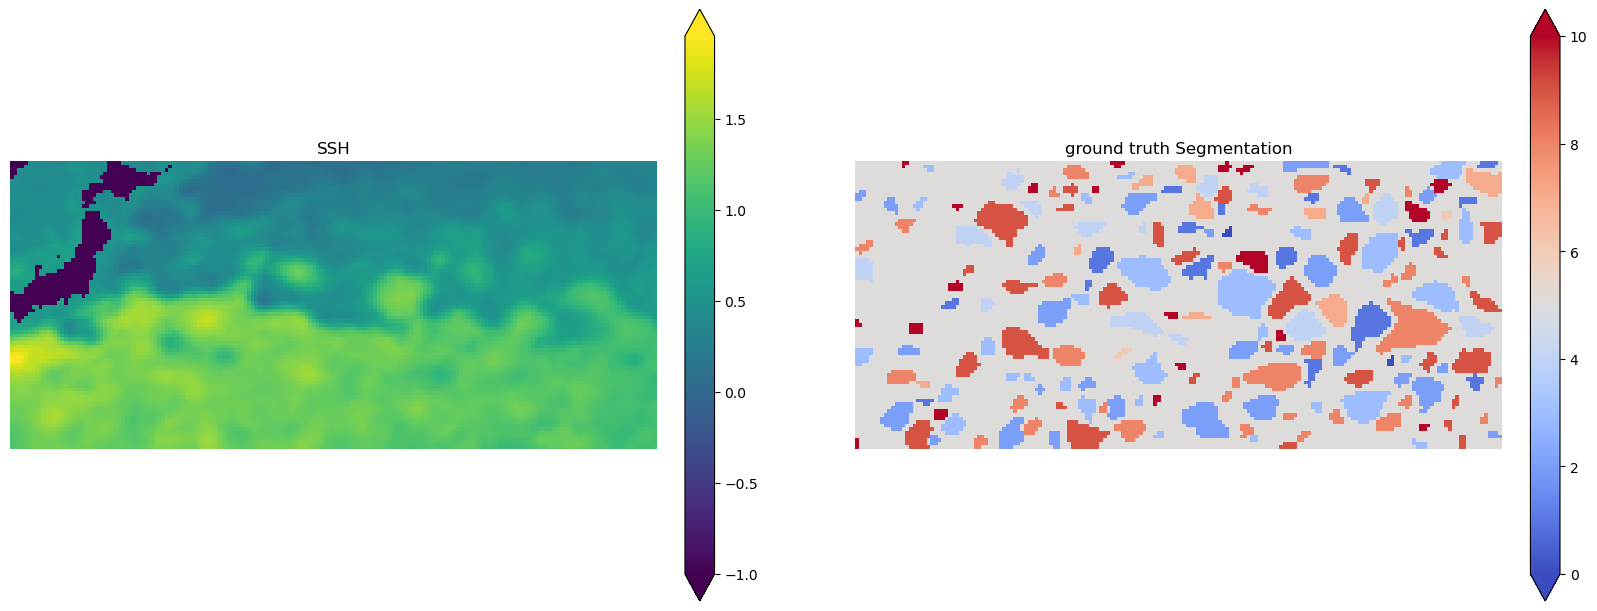

In [3]:
randindex=np.random.randint(0,len(SSH_train))

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(SSH_train[randindex,::-1,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(122)
plt.imshow(Seg_train[randindex,::-1,:,0], cmap='coolwarm')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

## EddyResNet 

This architecture is based on combining Unet and Residual units, here we show a small EddyResNet

In [4]:
from keras.models import Model, load_model
from keras.layers import Activation, Reshape, Permute, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, AlphaDropout, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, LeakyReLU, add
import keras.utils as utils   #更改代码
from keras.optimizers import legacy   #更改代码
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import pickle
from IPython.display import SVG 
from keras.utils import model_to_dot    #更改代码
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [5]:
Seg_train_categor = utils.to_categorical(np.reshape(Seg_train[:,:,:,0],(7305,80*180)),11)   #更改代码
Seg_train_categor.shape

(7305, 14400, 11)

In [6]:
def FirstResUnit(nf,ker,inputs):
    conv1 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv1)
    return add([conv2,inputs])

def ResUnit(nf,ker,inputs, drop=0.5):
    conv1 = BatchNormalization()(inputs)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(drop)(conv1)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(drop)(conv2)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv2)
    return add([conv2,inputs])

def ResUnitDecoder(nf,ker,inputs,drop=0.5):
    conv1 = BatchNormalization()(inputs)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(drop)(conv1)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(drop)(conv2)
    conv2 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(conv2)
    ###
    shortcut = Conv2D(nf, 1, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    return add([conv2,shortcut])

In [7]:
width = 180
height = 80
nbClass = 11
nf = 32
ker = 3

###################################### INPUT LAYER

img_input = Input(shape=(height, width, 1))
######################################ENCODER

conv1 = FirstResUnit(nf,ker,img_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = ResUnit(nf,ker,pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#######################################center

convC = ResUnit(nf,ker,pool2)

#######################################DECODER

up2 = concatenate([UpSampling2D((2,2))(convC), conv2])
decod2 = ResUnitDecoder(nf,ker,up2)

up1 = concatenate([UpSampling2D((2,2))(decod2), conv1])
decod1 = ResUnitDecoder(nf,ker,up1)

####################################### Segmentation Layer

x = Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)(decod1) 
x = Reshape((height * width, nbClass))(x) 
x = Activation("softmax")(x)
eddynet = Model(img_input, x)

eddynet.summary()

2024-03-20 02:53:35.514217: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-20 02:53:35.514260: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-20 02:53:35.514271: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-20 02:53:35.514569: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-20 02:53:35.514593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 180, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 180, 32)          288       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 80, 180, 32)          128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 80, 180, 32)          0         ['batch_normalization[0][0

### calculate weights (some heavy data imbalance out there...)

In [8]:
unique, counts = np.unique(Seg_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 103639,
 1.0: 2657999,
 2.0: 5320154,
 3.0: 6174869,
 4.0: 2255325,
 5.0: 73436975,
 6.0: 109126,
 7.0: 1917972,
 8.0: 4965973,
 9.0: 5937482,
 10.0: 2312486}

In [9]:
freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
weightsSeg

[0.45258770407895316,
 0.017647010801372997,
 0.00881661265125758,
 0.007596231930270686,
 0.020797772854483778,
 0.0006387209857573602,
 0.4298309941080827,
 0.024455902934473823,
 0.009445427323716546,
 0.007899937559901423,
 0.020283684771729916]

## loss functions

In [10]:
smooth = 1.  # to avoid zero division

def dice_coef_anti(y_true, y_pred):
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    y_true_cyc = y_true[:,:,2]
    y_pred_cyc = y_pred[:,:,2]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    return (0.35*dice_coef_anti(y_true, y_pred) + 0.62*dice_coef_cyc(y_true, y_pred) + 0.03*dice_coef_nn(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

In [11]:
eddynet.compile(optimizer=legacy.Nadam(lr=1e-2), loss=dice_coef_loss,    #更改代码
                metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

/Users/jjijack/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/optimizers/legacy/nadam.py:89: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
#SVG(model_to_dot(eddynet).create(prog='dot', format='svg'))

## Training

In [13]:
earl = EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=50, verbose=1, mode='auto')
modelcheck = ModelCheckpoint('./weights/eddyRESnet.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)


histeddynet=eddynet.fit(SSH_train, Seg_train_categor,
                              epochs=50,
                              batch_size=16,
                              shuffle=True,
                              verbose=1,
                              callbacks=[modelcheck,reducecall, earl],
                              validation_split=0.2
                              )

Epoch 1/50


2024-03-20 02:53:43.373144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


366/366 [==============================] - ETA: 0s - loss: 0.9404 - categorical_accuracy: 0.0506 - mean_dice_coef: 0.0337 - weighted_mean_dice_coef: 0.0596

2024-03-20 02:54:25.058893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.93922, saving model to ./weights/eddyRESnet.h5
366/366 [==============================] - 46s 116ms/step - loss: 0.9404 - categorical_accuracy: 0.0506 - mean_dice_coef: 0.0337 - weighted_mean_dice_coef: 0.0596 - val_loss: 0.9392 - val_categorical_accuracy: 0.0514 - val_mean_dice_coef: 0.0346 - val_weighted_mean_dice_coef: 0.0608 - lr: 0.0100
Epoch 2/50
366/366 [==============================] - ETA: 0s - loss: 0.9403 - categorical_accuracy: 0.0504 - mean_dice_coef: 0.0337 - weighted_mean_dice_coef: 0.0597
Epoch 2: val_loss did not improve from 0.93922
366/366 [==============================] - 41s 111ms/step - loss: 0.9403 - categorical_accuracy: 0.0504 - mean_dice_coef: 0.0337 - weighted_mean_dice_coef: 0.0597 - val_loss: 0.9392 - val_categorical_accuracy: 0.0514 - val_mean_dice_coef: 0.0346 - val_weighted_mean_dice_coef: 0.0608 - lr: 0.0100
Epoch 3/50
313/366 [========================>.....] - ETA: 5s - loss: 0.9404 - categorical_accuracy: 0.

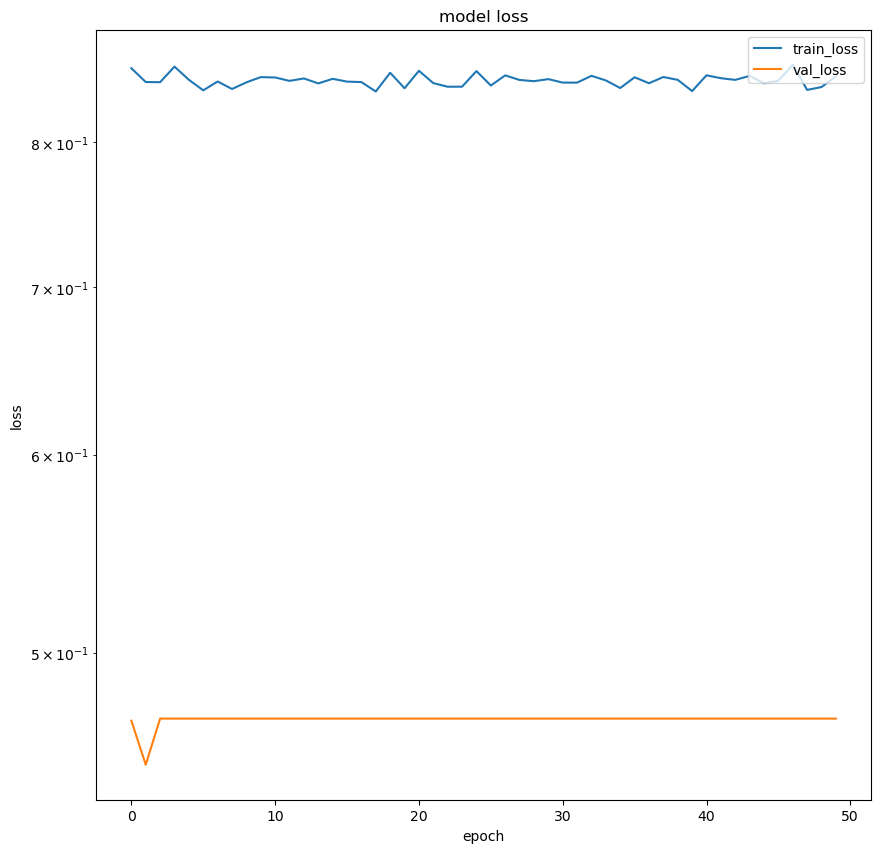

In [ ]:
plt.figure(figsize=(10, 10))
plt.semilogy(eddynet.history.history['loss'])
plt.semilogy(eddynet.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right');

## Performance on train dataset 
just to be sure...

2024-03-19 23:17:00.040838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


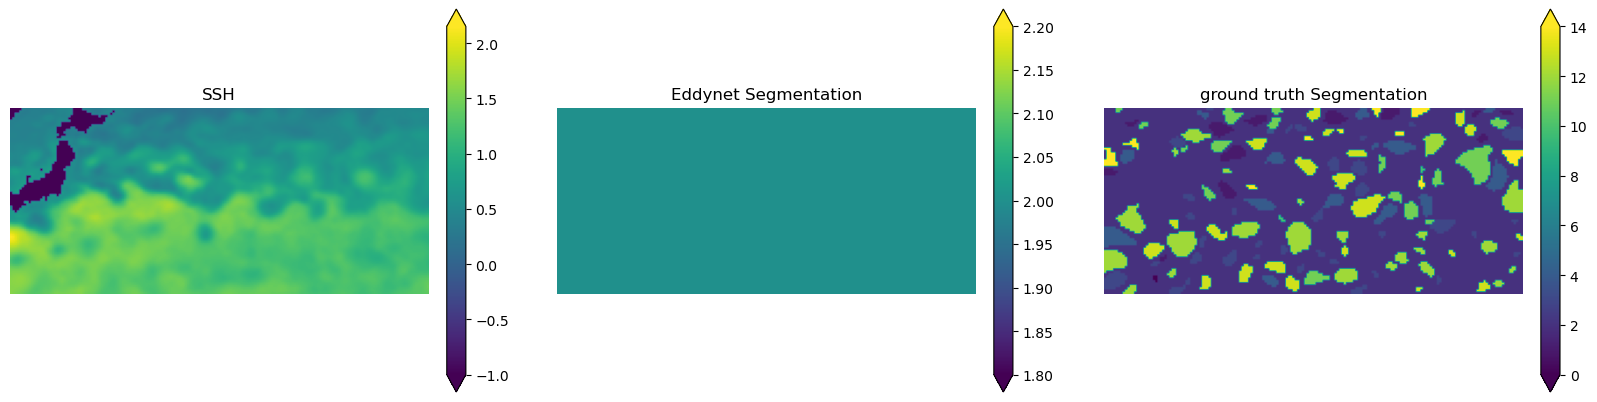

In [ ]:
randindex=np.random.randint(0,len(SSH_train))
predictedSEGM=eddynet.predict(np.reshape(SSH_train[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))
predictedSEGMimage=predictedSEGMimage[::-1,:]

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(SSH_train[randindex,::-1,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Eddynet Segmentation');

plt.subplot(133)
plt.imshow(Seg_train[randindex,::-1,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

## Performance on test dataset (2009 data)

1/1 [==============================] - 0s 29ms/step


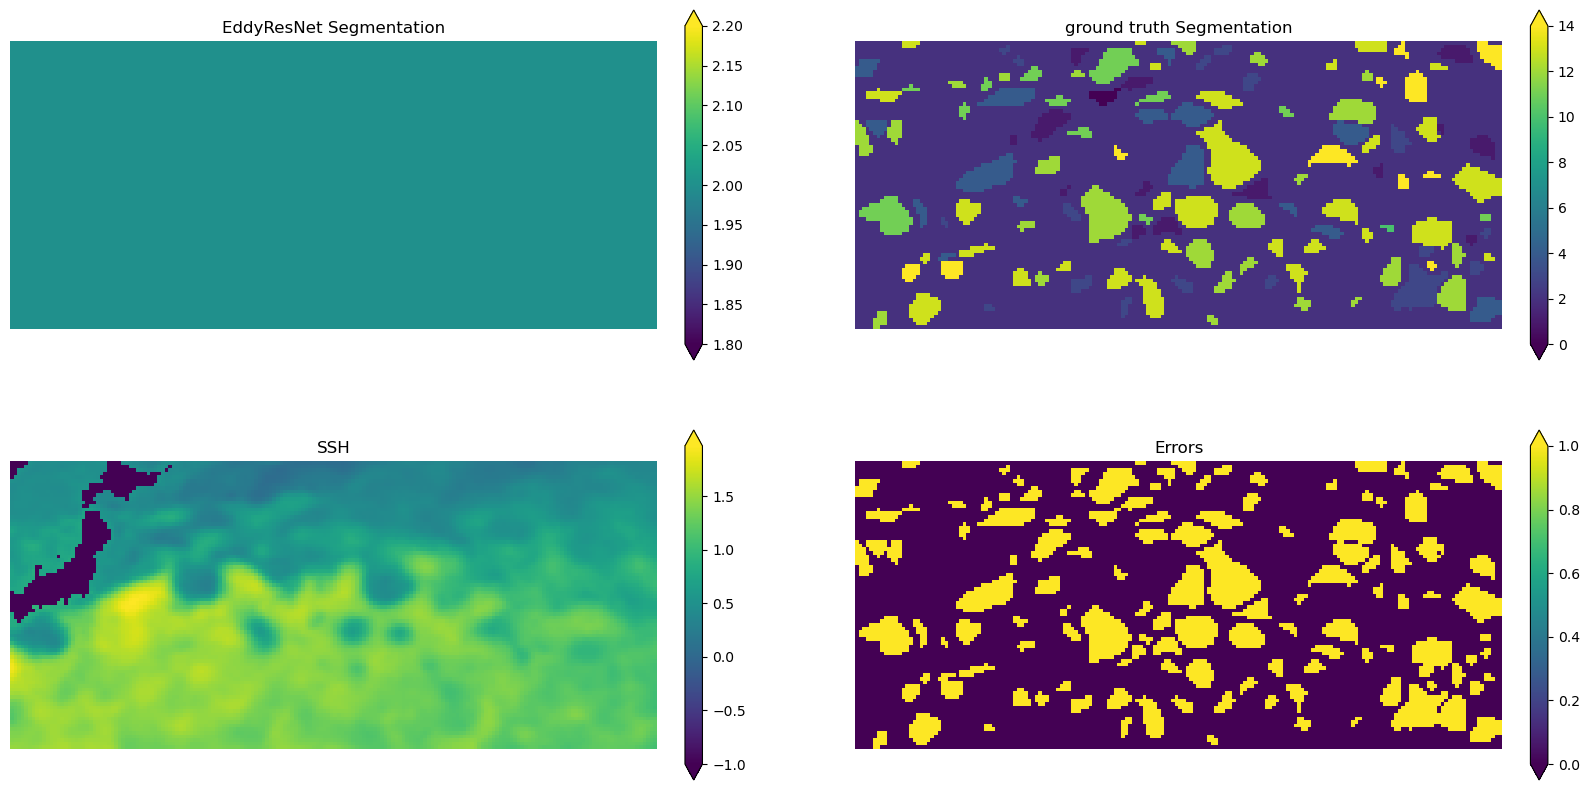

In [ ]:
randindex=np.random.randint(0,len(SSH_test))
predictedSEGM=eddynet.predict(np.reshape(SSH_test[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))
predictedSEGMimage=predictedSEGMimage[::-1,:]

plt.figure(figsize=(20, 10))

plt.subplot(221)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('EddyResNet Segmentation');

plt.subplot(222)
plt.imshow(Seg_test[randindex,::-1,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

plt.subplot(223)
plt.imshow(SSH_test[randindex,::-1,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(224)
plt.imshow(np.where(predictedSEGMimage == Seg_test[randindex,::-1,:,0], 0, 1))
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.axis('off')
plt.title('Errors');

In [ ]:
np.sum(np.where(predictedSEGMimage == Seg_test[randindex,::-1,:,0], 0, 1))

3397

Seems working nicely, but there are some false eddy detections that need to be dealt with.

On my new paper I show that combining EddyResNet with ideas from level set segmentation leads to better results, I'll post the code upon acceptance of the paper

## metrics on test dataset

In [ ]:
Seg_test_categor = utils.to_categorical(np.reshape(Seg_test[:,:,:,0],(365,80*180)),3)
Seg_test_categor.shape

(365, 14400, 3)

In [ ]:
eddynet.evaluate(SSH_test,Seg_test_categor)

12/12 [==============================] - 1s 66ms/step - loss: 0.2567 - categorical_accuracy: 0.8384 - mean_dice_coef: 0.7874 - weighted_mean_dice_coef: 0.7438


[0.2566577196121216,
 0.8383830189704895,
 0.7873563766479492,
 0.7437596321105957]

In [ ]:
#### if you wanna use some animations ;) 


#imageList=[]
#for i in range(1200,1400):
#    imageList.append(SSH_train[i,:,:,0])
  

#print('drawing the animation...')
#from matplotlib import animation, rc
#from IPython.display import HTML

#def getImageFromList(x):
#    return imageList[x]

#fig = plt.figure(figsize=(10, 10))
#ims = []
#for i in range(len(imageList)):
#    im = plt.imshow(getImageFromList(i), animated=True, cmap='viridis')
#    ims.append([im])
#plt.axis('off')

#ani = animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat=False)
#plt.close()

#HTML(ani.to_jshtml())